In [1]:
import time
import pandas as pd
import numpy as np
import util
import pyBigWig
import seaborn as sns
import glob
from matplotlib_venn import venn2,venn3
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tic=time.time()

def get_cg(x):
    cg=set(range(x['b'],x['e']))
    cg=ind[x['ch']].intersection(cg)
    return cg
def hmr2df(hmr):
    gs=pd.read_table(hmr,header=None,usecols=[0,1,2])
    gs=gs[~gs[0].isin(['chrX','chrY','chrM'])]
    print(len(gs),end=',')
    gs.columns=['ch','b','e']   
    gs['d']=gs['e']-gs['b']
    gs['r']=gs.apply(lambda x:get_cg(x) ,axis=1)
    gs['rd']=gs.r.apply(lambda x:len(x))
    gs.index=gs['ch']+'_'+gs['b'].astype(str)
    gg=gs.groupby('ch')['r'].apply(list)
    gg=gg.apply(lambda x:set.union(*x))    
    return (gs,gg)   
def get_ts(x):
    chrom=x['ch']
    com=set(range(x['b'],x['e'])).intersection(expg[chrom])
    if len(com)>0:
        ts=list(com)[0]
        ts=exp.loc[(exp['chrom']==int(chrom[3:])) & (exp.ts==ts)].index.values[0]
    else:
        ts=np.nan
    return(ts)

In [2]:
ind=pd.read_table('data/meth/h/Human_H1.meth',engine='c',usecols=[0,1],header=None)
ind=ind.groupby(0)[1].apply(list)
ind=ind.apply(lambda x:set(x))

In [3]:
samples=['s','t','h']
c={}
cg={}
cu={}
cug={}

In [4]:
for s in samples:
    c[s],cg[s]=hmr2df('data/meth/'+s+'/'+s+'.hmr')

95351,52648,39517,

In [5]:
c['t']['s']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)
c['t']['sh']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)
c['s']['t']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)
c['s']['th']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)

In [6]:
c['h']['t']=c['h'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)
c['h']['s']=c['h'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)

In [8]:
c['t']

,ch,b,e,d,r,rd,s,sh
chr1_10619,chr1,10619,10638,19,"{10630, 10632, 10635, 10637, 10619}",5,5,0
chr1_28511,chr1,28511,29403,892,"{28676, 29193, 28691, 29204, 29214, 28704, 292...",77,77,77
chr1_91118,chr1,91118,91580,462,"{91232, 91457, 91266, 91118, 91471, 91188, 911...",9,9,0
chr1_267304,chr1,267304,268126,822,"{267811, 268036, 268067, 267304, 267594, 26804...",17,0,0
chr1_586153,chr1,586153,586280,127,"{586279, 586153, 586221, 586190, 586196, 586204}",6,6,6
...,...,...,...,...,...,...,...,...
chr9_138022498,chr9,138022498,138023971,1473,"{138022914, 138023939, 138023430, 138023942, 1...",157,157,157
chr9_138054369,chr9,138054369,138054652,283,"{138054369, 138054593, 138054504, 138054539, 1...",10,0,0
chr9_138147555,chr9,138147555,138148043,488,"{138147968, 138147712, 138147970, 138147973, 1...",45,29,24
chr9_138149866,chr9,138149866,138150700,834,"{138150659, 138150533, 138150407, 138150152, 1...",73,73,23


In [7]:
print(round(c['t']['rd'].sum()/10**3),
      round(c['t']['s'].sum()/10**3),
      round(c['t'][c['t']['s']>0]['sh'].sum()/10**3))
print(round(c['s']['rd'].sum()/10**3),
      round(c['s']['t'].sum()/10**3),
      round(c['s'][c['s']['t']>0]['th'].sum()/10**3))

2609 2352 2144
3486 2352 2144


In [9]:
ct,cs,ch=[],[],[]
for i,r in c['t'].iterrows():
    for j in list(r['r']):
        ct.append(r['ch']+'_'+str(j))
for i,r in c['s'].iterrows():
    for j in list(r['r']):
        cs.append(r['ch']+'_'+str(j)) 
for i,r in c['h'].iterrows():
    for j in list(r['r']):
        ch.append(r['ch']+'_'+str(j))        

In [10]:
pd.DataFrame(ct).to_csv('data/ti.csv',index=False,header=False)
pd.DataFrame(cs).to_csv('data/si.csv',index=False,header=False)
pd.DataFrame(ch).to_csv('data/hi.csv',index=False,header=False)

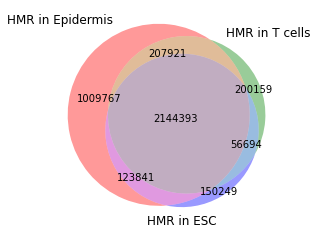

In [11]:
subsets=(set(cs),set(ct),set(ch))
v=venn3(subsets = subsets, set_labels = ('HMR in Epidermis', 'HMR in T cells','HMR in ESC'))

In [12]:
for s in ['s','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        c[s][n]=c[s].apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    c[s]['dd']=c[s]['o']-c[s]['y']
    cu[s]=c[s][c[s]['dd']>.1]
    cug[s]=cu[s].groupby('ch')['r'].apply(list)
    cug[s]=cug[s].apply(lambda x:set.union(*x))                   

In [13]:
cu['t']['su']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(x['r'])),1)
cu['t']['suh']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)
cu['s']['tu']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(x['r'])),1)
cu['s']['tuh']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)

In [14]:
print(round(cu['t'].rd.sum()/10**3),
      round(cu['t']['su'].sum()/10**3),
      round(cu['t'][cu['t']['su']>0]['suh'].sum()/10**3))
print(round(cu['s'].rd.sum()/10**3),
      round(cu['s']['tu'].sum()/10**3),
      round(cu['s'][cu['s']['tu']>0]['tuh'].sum()/10**3))

259 27 15
95 27 15


In [15]:
cu['s'].d.sum()/10**6

2.528111

In [16]:
cu['t'][['ch','b','e','su','suh']].to_csv('data/tu.csv')
cu['s'][['ch','b','e','tu','tuh']].to_csv('data/su.csv')

In [17]:
ct,cs,=[],[]
for i,r in cu['t'].iterrows():
    for j in list(r['r']):
        ct.append(r['ch']+'_'+str(j))
for i,r in cu['s'].iterrows():
    for j in list(r['r']):
        cs.append(r['ch']+'_'+str(j)) 

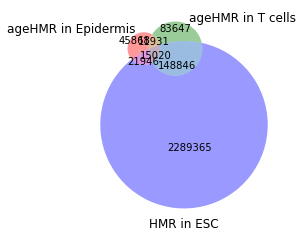

In [18]:
subsets=(set(cs),set(ct),set(ch))
venn3(subsets = subsets, set_labels = ('ageHMR in Epidermis', 'ageHMR in T cells','HMR in ESC'))

In [23]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
ts=cu['t'][cu['t']['su']>0]
st=cu['s'][cu['s']['tu']>0]
bs=[]
for i,r in ts.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
ts['ez']=bs    
bs=[]
for i,r in st.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
st['ez']=bs    

In [24]:
#st[st.ez>100][['ch','b','e']].to_csv('data/tsz.bed',sep='\t',header=False,index=False)

In [25]:
print(ts[ts.suh==0].ez.mean(),ts[ts.suh>0].ez.mean())
print(st[st.tuh==0].ez.mean(),st[st.tuh>0].ez.mean())

2.892130427157452 40.63913004243051
2.9151432654522944 40.820904419018945


In [26]:
ts['suhb']=ts['suh']>0
st['tuhb']=st['tuh']>0

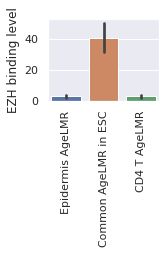

In [27]:
sns.set(rc={'figure.figsize':(2,1.5)})
tst=ts.append(st[~st.tuhb])
tst.loc[tst.tuhb==False,'group']='CD4 T AgeLMR'
tst.loc[tst.suhb==False,'group']='Epidermis AgeLMR'
tst=tst.fillna('Common AgeLMR in ESC')
ax=sns.barplot(data=tst[['group','ez']],x='group',y='ez')
ax.set(xlabel='',ylabel='EZH binding level');
plt.xticks(rotation=90);

In [27]:
############################
############################

In [34]:
h=c['h'].copy()
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in h.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
h['ez']=bs

In [36]:
h[['ch','b','e','d','rd','ez']].to_csv('data/h.csv')

In [39]:
hz=h[h.ez>100].copy()

In [40]:
tss=pd.read_csv('data/tss.csv',index_col=0)
exp=pd.read_csv('data/exp.csv',index_col=0)
exp['ch']='chr'+exp['chrom'].astype(str)
expg=exp.groupby('ch')['ts'].apply(list)
hz['ts']=hz.apply(lambda x: get_ts(x),axis=1)
hzt=hz[hz.ts.notna()]
len(hzt)

587